# Explorative Analysis

## Reading data

In [7]:
import pandas as pd
import json

In [8]:
train = pd.read_csv('data/train.csv')
train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [66]:
import glob
test_images = glob.glob("./data/test_images/*.jpg")
test_images

['./data/test_images/2216849948.jpg']

## Enhance training with human readable labels

In [15]:
with open('data/label_num_to_disease_map.json') as f:
    label_num_to_disease_map = json.load(f)
label_num_to_disease_map

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [16]:
label_num_to_disease_map['0']

'Cassava Bacterial Blight (CBB)'

In [21]:
label_num_to_disease_map_int = dict()
for i in label_num_to_disease_map:
    label_num_to_disease_map_int[int(i)] = label_num_to_disease_map[i]
label_num_to_disease_map_int

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [22]:
train['label_description'] = train['label'].apply(lambda x: label_num_to_disease_map_int[x])

## Label distribution

In [24]:
train.groupby(['label','label_description']).count()

image_id
label label_description                            
0     Cassava Bacterial Blight (CBB)           1087
1     Cassava Brown Streak Disease (CBSD)      2189
2     Cassava Green Mottle (CGM)               2386
3     Cassava Mosaic Disease (CMD)            13158
4     Healthy                                  2577

In [67]:
train.groupby(['label','label_description']).count()/len(train)

image_id
label label_description                            
0     Cassava Bacterial Blight (CBB)       0.050802
1     Cassava Brown Streak Disease (CBSD)  0.102304
2     Cassava Green Mottle (CGM)           0.111511
3     Cassava Mosaic Disease (CMD)         0.614946
4     Healthy                              0.120437

The trainingset seems highly unbalanced

# Looking at images

## Are all images in the same format?

In [27]:
from PIL import Image
def get_image_info(path):
    with Image.open('data/train_images/'+path) as im:
        return {'format':im.format, 'width':im.size[0], 'height':im.size[1], 'mode':im.mode}

In [28]:
image_info = train['image_id'].apply(get_image_info)

In [38]:
pd.DataFrame.from_records(image_info).describe(include='all')

format    width   height   mode
count   21397  21397.0  21397.0  21397
unique      1      NaN      NaN      1
top      JPEG      NaN      NaN    RGB
freq    21397      NaN      NaN  21397
mean      NaN    800.0    600.0    NaN
std       NaN      0.0      0.0    NaN
min       NaN    800.0    600.0    NaN
25%       NaN    800.0    600.0    NaN
50%       NaN    800.0    600.0    NaN
75%       NaN    800.0    600.0    NaN
max       NaN    800.0    600.0    NaN

All 800x600 JPEG RGB

## Looking at some example images

In [39]:
from matplotlib.pyplot import imshow, figure, title
import numpy as np

In [40]:
samples = train.sample(frac=1).groupby('label').head(3)
samples = samples.sort_values(by='label')
samples

image_id  label                    label_description
8471   2503003890.jpg      0       Cassava Bacterial Blight (CBB)
17834   421071700.jpg      0       Cassava Bacterial Blight (CBB)
14800  3653286071.jpg      0       Cassava Bacterial Blight (CBB)
714    1123691141.jpg      1  Cassava Brown Streak Disease (CBSD)
16156  3910758251.jpg      1  Cassava Brown Streak Disease (CBSD)
10236  2824583085.jpg      1  Cassava Brown Streak Disease (CBSD)
3390   1593413079.jpg      2           Cassava Green Mottle (CGM)
20821   884267453.jpg      2           Cassava Green Mottle (CGM)
16504  3966975834.jpg      2           Cassava Green Mottle (CGM)
17199  4098206524.jpg      3         Cassava Mosaic Disease (CMD)
17985  4240296796.jpg      3         Cassava Mosaic Disease (CMD)
8197   2456612393.jpg      3         Cassava Mosaic Disease (CMD)
16955  4049843068.jpg      4                              Healthy
20935    90670123.jpg      4                              Healthy
4303   1769025995.jpg      4                              Healthy

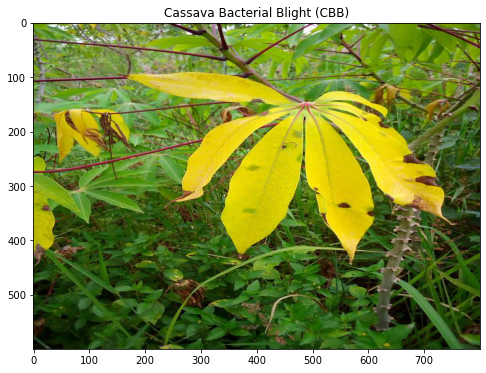

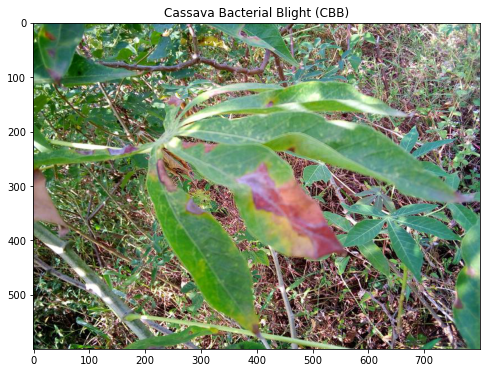

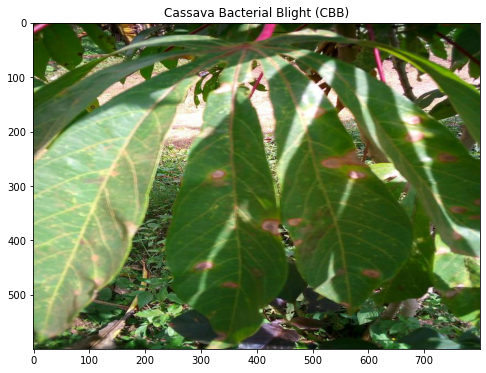

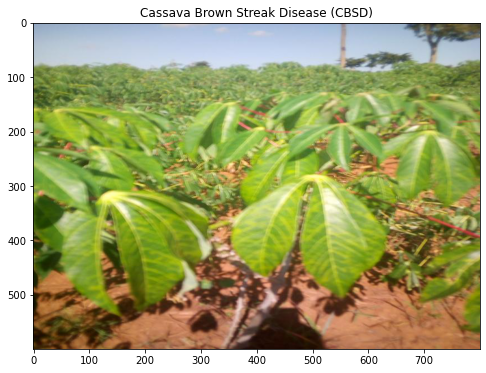

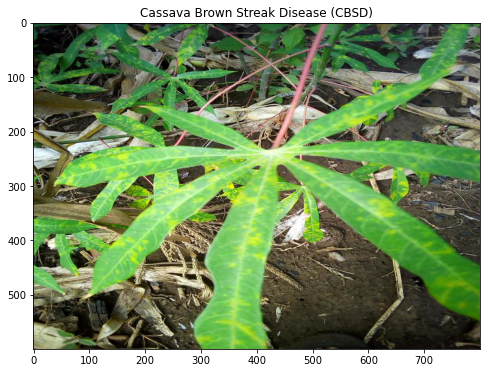

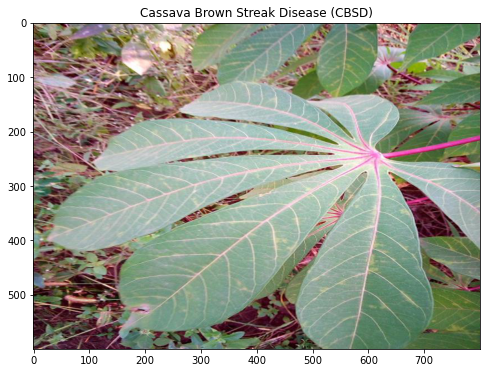

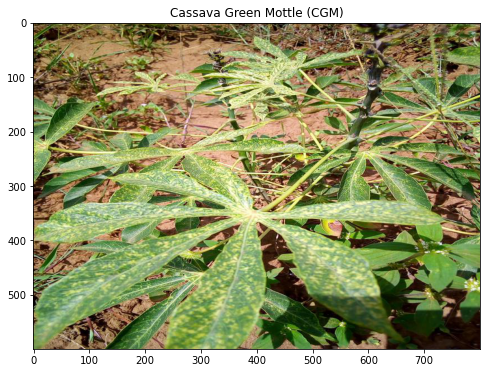

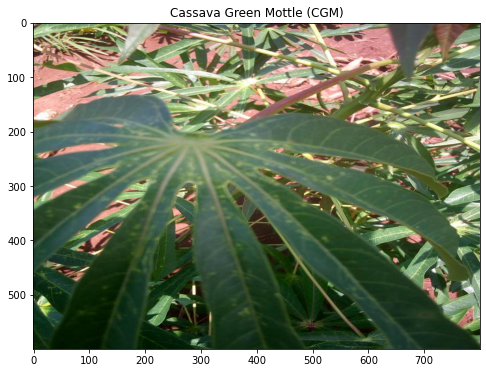

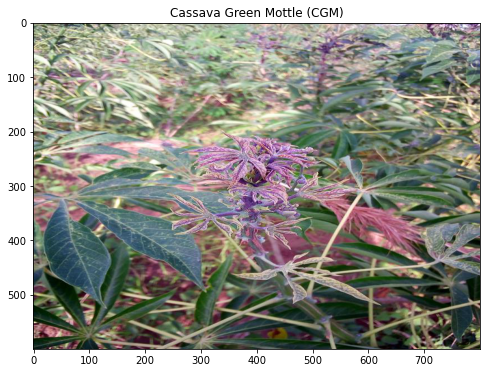

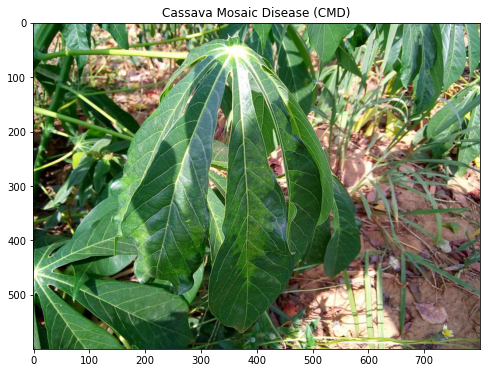

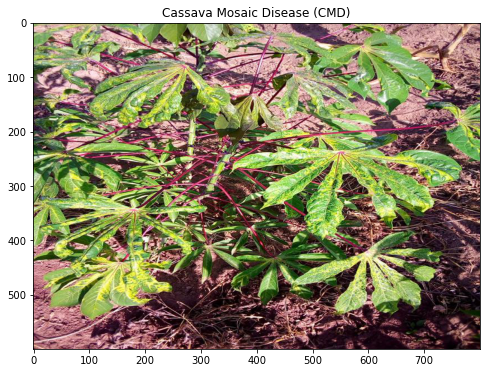

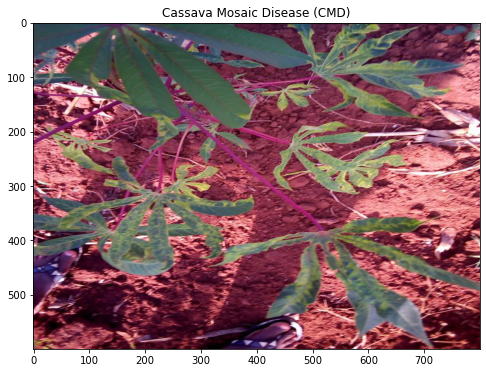

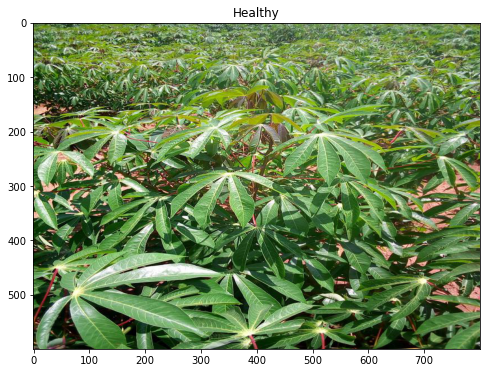

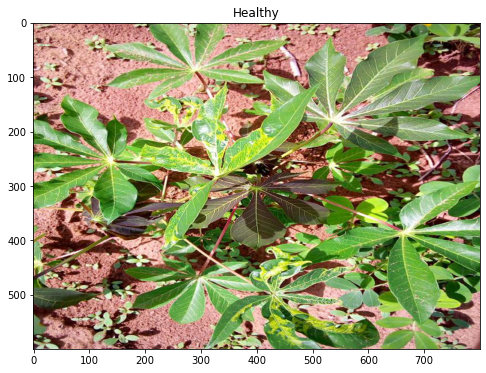

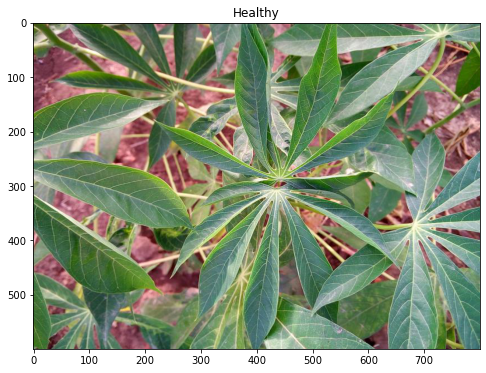

In [45]:
for _, img in samples.iterrows():
    with Image.open('data/train_images/'+img['image_id']) as im:
        figure(figsize=(8,6))
        title(img['label_description'])
        imshow(np.asarray(im), aspect='auto')

## Let's look at some simple color statistics

In [46]:
def color_stats(img_path):
    with Image.open(img_path) as im:
        img_arr = np.asarray(im)
        [red_mean, green_mean, blue_mean] = np.mean(img_arr,axis=(0,1))
        [red_std, green_std, blue_std] = np.std(img_arr,axis=(0,1))
        [red_max, green_max, blue_max] = np.max(img_arr,axis=(0,1))
        [red_min, green_min, blue_min] = np.min(img_arr,axis=(0,1))
        return {'red_mean':red_mean, 'green_mean':green_mean, 'blue_mean':blue_mean,
                'red_std':red_std, 'green_std':green_std, 'blue_std':blue_std,
                'red_max':red_max, 'green_max':green_max, 'blue_max':blue_max,
                'red_min':red_min, 'green_min':green_min, 'blue_min':blue_min}


In [49]:
import pandas
import os.path

if not os.path.isfile('image_info.csv'): 
    image_stats = [color_stats(path) for path in 'data/train_images/'+train['image_id']]
    images = pd.DataFrame.from_records(image_stats)
    images.to_csv('image_info.csv', index=False)
else:
    images = pandas.read_csv('image_info.csv')

In [50]:
images.head()

red_mean  green_mean  blue_mean    red_std  green_std   blue_std  \
0   92.876550  107.734904  51.975710  68.876704  62.152981  58.661889   
1  128.151565  132.407623  83.088573  53.507676  59.005285  49.174667   
2   72.915002  132.987971  55.322179  36.085387  44.291392  35.199476   
3   89.627144  145.065156  53.085321  49.254504  46.457459  43.526271   
4   87.819050  113.421190  77.696731  74.572849  59.889572  62.474792   

   red_max  green_max  blue_max  red_min  green_min  blue_min  
0      255        255       255        0          0         0  
1      255        255       255        0          0         0  
2      255        255       255        0          5         0  
3      255        255       255        0          0         0  
4      255        255       250        0          0         0

In [51]:
images['red_range']=images['red_max']-images['red_min']
images['green_range']=images['green_max']-images['green_min']
images['blue_range']=images['blue_max']-images['blue_min']

In [52]:
images.describe()

red_mean    green_mean     blue_mean       red_std     green_std  \
count  21397.000000  21397.000000  21397.000000  21397.000000  21397.000000   
mean     109.730529    126.665405     79.945870     55.988455     57.186900   
std       21.687389     20.402001     26.117682      8.887539      9.080655   
min       22.775415     41.898996      3.300608     23.962208     18.107613   
25%       94.843527    111.496015     61.857629     49.816865     51.243101   
50%      109.497842    127.203946     79.044962     56.197541     57.791990   
75%      125.332319    142.135427     98.316954     62.559765     63.705099   
max      221.605588    221.087727    202.003613     92.962364     94.344378   

           blue_std       red_max     green_max      blue_max       red_min  \
count  21397.000000  21397.000000  21397.000000  21397.000000  21397.000000   
mean      51.332663    254.827499    254.882320    253.838295      0.365799   
std        9.415503      2.048080      1.779929      5.767479      2.831927   
min        7.743013    190.000000    156.000000    143.000000      0.000000   
25%       45.495594    255.000000    255.000000    255.000000      0.000000   
50%       51.293368    255.000000    255.000000    255.000000      0.000000   
75%       56.688257    255.000000    255.000000    255.000000      0.000000   
max      107.675094    255.000000    255.000000    255.000000     68.000000   

          green_min      blue_min     red_range   green_range    blue_range  
count  21397.000000  21397.000000  21397.000000  21397.000000  21397.000000  
mean       0.355424      0.038276    254.461700    254.526896    253.800019  
std        3.016205      1.025057      3.536868      3.606237      5.914844  
min        0.000000      0.000000    165.000000    156.000000    143.000000  
25%        0.000000      0.000000    255.000000    255.000000    255.000000  
50%        0.000000      0.000000    255.000000    255.000000    255.000000  
75%        0.000000      0.000000    255.000000    255.000000    255.000000  
max       81.000000     58.000000    255.000000    255.000000    255.000000

In [61]:
train_images = train.join(images)

In [62]:
train_images[train_images['blue_std']<9]

image_id  label                    label_description    red_mean  \
12620  326197492.jpg      1  Cassava Brown Streak Disease (CBSD)  171.482394   

       green_mean  blue_mean    red_std  green_std  blue_std  red_max  \
12620  174.632977   3.868802  33.506382  27.488009  7.743013      253   

       green_max  blue_max  red_min  green_min  blue_min  red_range  \
12620        251       143        1          0         0        252   

       green_range  blue_range  
12620          251         143

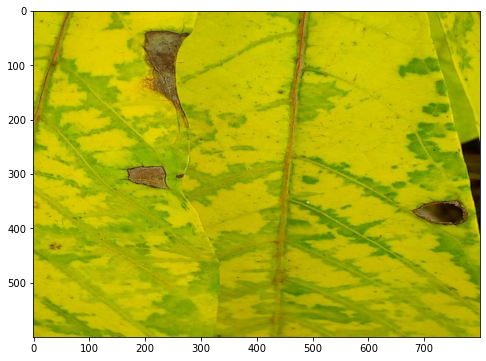

In [64]:
with Image.open('data/train_images/326197492.jpg') as im:
        figure(figsize=(8,6))
        imshow(np.asarray(im), aspect='auto')